In [1]:
import pandas as pd
import numpy as np

path = "../IEEE TSE2018/dataset/appceleratorstudio.csv"
df = pd.read_csv(path, usecols=['issuekey', 'title', 'description', 'storypoint'])

In [2]:
df.isnull().sum()

issuekey        0
title           0
description    43
storypoint      0
dtype: int64

In [3]:
df = df.dropna(how='any')

In [4]:
df.head()

,issuekey,title,description,storypoint
0,TISTUD-6,Add CA against object literals in function inv...,{html}<div><p>The idea here is that if our met...,1
1,TISTUD-9,Update branding for Appcelerator plugin to App...,"{html}<div><p>At least fix feature icons, asso...",1
2,TISTUD-11,Create new JSON schema for SDK team,{html}<div><p>Create JSON schema containing pr...,1
3,TISTUD-13,Create Project References Property Page,{html}<div><p>Create property page for project...,1
4,TISTUD-16,New Desktop Project Wizard,{html}<div><p>Desktop (need to convert existin...,1


In [5]:
df.storypoint.describe()

count    2876.000000
mean        5.636300
std         3.309936
min         1.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        40.000000
Name: storypoint, dtype: float64

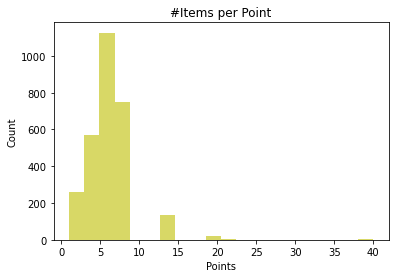

In [6]:
import matplotlib.pyplot as plt
 
plt.hist(df.storypoint, bins=20, alpha=0.6, color='y')
plt.title("#Items per Point")
plt.xlabel("Points")
plt.ylabel("Count")
 
plt.show()

In [7]:
df.groupby('storypoint').size()

storypoint
1      148
2      112
3      571
5     1126
8      751
9        1
13     137
20      22
21       3
34       1
40       4
dtype: int64

### Data Preprocessing

In [8]:
df.loc[df.storypoint <= 2, 'storypoint'] = 0 #small
df.loc[(df.storypoint > 2) & (df.storypoint <= 5), 'storypoint'] = 1 #medium
df.loc[df.storypoint > 5, 'storypoint'] = 2 #big

In [9]:
df.groupby('storypoint').size()

storypoint
0     260
1    1697
2     919
dtype: int64

In [10]:
import re
from nltk.corpus import stopwords

#Clean operation
#Remove english stop words and html tokens

def cleanData(text):
    #Remove all tags
    text = re.compile(r'<.*?>').sub('', text)
    #Remove web urls
    text = re.compile(r'http\S+').sub('', text)
    #Remove {html} tag
    text = text.replace('{html}', '')
    
    text_words = text.split()    
    
    resultwords  = [word for word in text_words if word not in stopwords.words('english')]
    
    if len(resultwords) > 0:
        result = ' '.join(resultwords)
    else:
        print('Empty transformation for: ' + text)
        
    return result

def formatFastTextClassifier(label):
    return "__label__" + str(label) + " "

In [11]:
import nltk

nltk.download('stopwords')

df['title_desc'] = df['title'].str.lower() + ' - ' + df['description'].str.lower()
df['label_title_desc'] = df['storypoint'].apply(lambda x: formatFastTextClassifier(x)) + df['title_desc'].apply(lambda x: cleanData(str(x)))

df = df.reset_index(drop=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hawkp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
from collections import Counter

def SimpleOverSample(_xtrain, _ytrain):
    xtrain = list(_xtrain)
    ytrain = list(_ytrain)

    samples_counter = Counter(ytrain)
    max_samples = sorted(samples_counter.values(), reverse=True)[0]
    for sc in samples_counter:
        init_samples = samples_counter[sc]
        samples_to_add = max_samples - init_samples
        if samples_to_add > 0:
            #collect indices to oversample for the current class
            index = list()
            for i in range(len(ytrain)):
                if(ytrain[i] == sc):
                    index.append(i)
            #select samples to copy for the current class    
            copy_from = [xtrain[i] for i in index]
            index_copy = 0
            for i in range(samples_to_add):
                xtrain.append(copy_from[index_copy % len(copy_from)])
                ytrain.append(sc)
                index_copy += 1
    return xtrain, ytrain

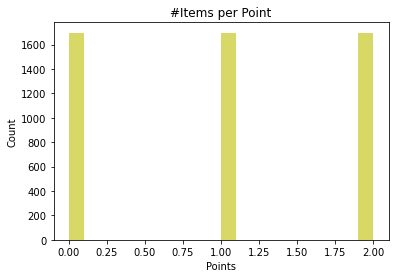

In [13]:
df_oversampled = pd.DataFrame(df, columns=['label_title_desc','storypoint'])
X_resampled, y_resampled =  SimpleOverSample(df_oversampled.label_title_desc.values.tolist(), df_oversampled.storypoint.values.tolist())

plt.hist(y_resampled, bins=20, alpha=0.6, color='y')
plt.title("#Items per Point")
plt.xlabel("Points")
plt.ylabel("Count")
plt.show()

### Creating pretrained vectors

In [14]:
root = '../IEEE TSE2018/pretrain data/'

pretrain_files = ['apache_pretrain.csv', 
                  'jira_pretrain.csv', 
                  'spring_pretrain.csv', 
                  'talendforge_pretrain.csv', 
                  'moodle_pretrain.csv',
                  'appcelerator_pretrain.csv',
                  'duraspace_pretrain.csv',
                  'mulesoft_pretrain.csv',
                  'lsstcorp_pretrain.csv']

pretrained = None

for file in pretrain_files:
    df_pretrain = pd.read_csv(root + file, usecols=['issuekey', 'title', 'description'])
    if(pretrained is not None):
        pretrained = pd.concat([pretrained, df_pretrain])
    else:
        pretrained = df_pretrain

pretrained = pretrained.dropna(how='any')

In [15]:
#pretrained['title_desc'] = (pretrained['title'].str.lower() + ' - ' + pretrained['description'].str.lower()).apply(lambda x: cleanData(str(x)))
#pretrained.to_pickle('pretrained_df.pkl')
pretrained = pd.read_pickle('pretrained_df.pkl')

In [16]:
outfile=open("issues_pretrain.txt", mode="w", encoding="utf-8")
for line in pretrained.title_desc.values:
    outfile.write(line + '\n')
outfile.close()

In [17]:
import os

#command = "fasttext skipgram -input issues_pretrain.txt -output pretrained_model -epoch 100 -wordNgrams 4 -dim 300 -minn 4 -maxn 6 -lr 0.01"
#os.system(command)

### Model Training and Results

In [18]:
import uuid

class FastTextClassifier:
    
    folderName = ""
    trainFileName = ""
    testFileName = ""
    pretrainedModelName = ""
    outputModelName = ""
    outputFileName = ""
    logFolderName = ""
    
    
    def __init__(self):
        self.rand = str(uuid.uuid4())
        self.trainFileName = "issues_train_" + self.rand + ".txt"
        self.testFileName = "issues_test_" + self.rand + ".txt"
        self.pretrainedModelName = "pretrained_model" + ".vec"
        self.outputModelName = "supervised_classifier_model_" + self.rand
        self.outputFileName = "predicted_results_" + self.rand + ".txt"
        self.logFolderName = "logfiles_" + self.rand
        
        command = "mkdir " + self.logFolderName
        os.system(command)
        
    
    def fit(self, xtrain, ytrain):
        #log folder path
        
        trainFilePath = self.logFolderName + "/" +self.trainFileName
        outputModelPath = self.logFolderName + "/" +self.outputModelName
        
        outfile=open(trainFilePath, mode="w", encoding="utf-8")
        for i in range(len(xtrain)):
            #line = "__label__" + str(ytrain[i]) + " " + xtrain[i]
            line = xtrain[i]
            outfile.write(line + '\n')
        outfile.close()            
        
        #fit data to model and save it
        command = "fasttext supervised -input " + trainFilePath + " -output " + outputModelPath + " -epoch 500 -wordNgrams 4 -dim 300 -minn 4 -maxn 6 -pretrainedVectors " + self.pretrainedModelName
        os.system(command)
        
        
    def predict(self, xtest):
        #log folder path
        testFilePath = self.logFolderName + "/" +self.testFileName
        outputFilePath = self.logFolderName + "/" +self.outputFileName
        outputModelPath = self.logFolderName + "/" +self.outputModelName
        
        #save test file
        outfile=open(testFilePath, mode="w", encoding="utf-8")
        for i in range(len(xtest)):
            outfile.write(xtest[i] + '\n')
        outfile.close()
        
        #get predictions     
        command =  "fasttext predict " + outputModelPath + ".bin " + testFilePath + " > " + outputFilePath
        os.system(command)
        
        outfile=open(outputFilePath, mode="r")
        test_pred = [int(line.strip('_label\r\n')) for line in outfile.readlines()]
        outfile.close()
                
        return test_pred

In [19]:
def rebuild_kfold_sets(folds, k, i):
    training_set = None
    testing_set = None

    for j in range(k):
        if(i==j):
            testing_set = folds[i]
        elif(training_set is not None):
            training_set = pd.concat([training_set, folds[j]])
        else:
            training_set = folds[j]
    
    return training_set, testing_set

In [20]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_confusion_matrix_with_accuracy(classes, y_true, y_pred, title, sum_overall_accuracy, total_predictions):
    cm = ConfusionMatrix(y_true, y_pred)
    
    print('Current Overall accuracy: ' + str(cm.stats()['overall']['Accuracy']))
    if total_predictions != 0:
        print('Total Overall Accuracy: ' + str(sum_overall_accuracy/total_predictions))
    else:
        print('Total Overall Accuracy: ' + str(cm.stats()['overall']['Accuracy']))

    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure()
    plot_confusion_matrix(conf_matrix, classes=classes, title=title)
    plt.show()

C:\Users\hawkp\anaconda3\lib\site-packages\pandas_ml\confusion_matrix\stats.py:60: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  num = df[df > 1].dropna(axis=[0, 1], thresh=1).applymap(lambda n: choose(n, 2)).sum().sum() - np.float64(nis2 * njs2) / n2


Current Overall accuracy: 0.6469565217391304
Total Overall Accuracy: 0.6469565217391304


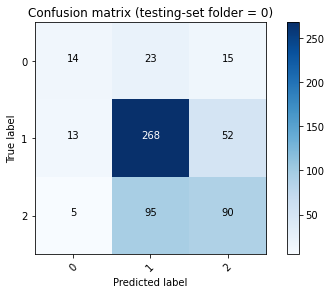

C:\Users\hawkp\anaconda3\lib\site-packages\pandas_ml\confusion_matrix\stats.py:60: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  num = df[df > 1].dropna(axis=[0, 1], thresh=1).applymap(lambda n: choose(n, 2)).sum().sum() - np.float64(nis2 * njs2) / n2


Current Overall accuracy: 0.6365217391304347
Total Overall Accuracy: 0.6417391304347826


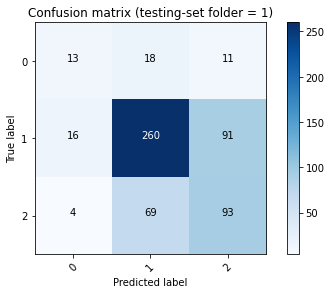

Current Overall accuracy: 0.6069565217391304
Total Overall Accuracy: 0.6301449275362319


C:\Users\hawkp\anaconda3\lib\site-packages\pandas_ml\confusion_matrix\stats.py:60: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  num = df[df > 1].dropna(axis=[0, 1], thresh=1).applymap(lambda n: choose(n, 2)).sum().sum() - np.float64(nis2 * njs2) / n2


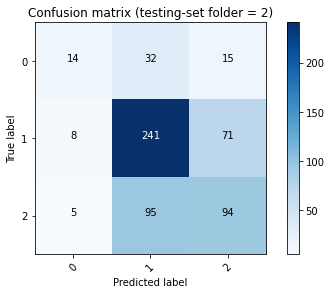

C:\Users\hawkp\anaconda3\lib\site-packages\pandas_ml\confusion_matrix\stats.py:60: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  num = df[df > 1].dropna(axis=[0, 1], thresh=1).applymap(lambda n: choose(n, 2)).sum().sum() - np.float64(nis2 * njs2) / n2


Current Overall accuracy: 0.6121739130434782
Total Overall Accuracy: 0.6256521739130435


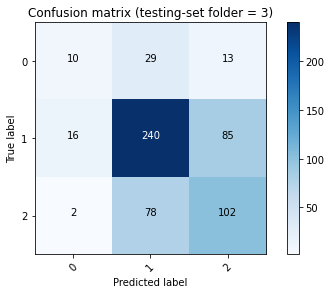

C:\Users\hawkp\anaconda3\lib\site-packages\pandas_ml\confusion_matrix\stats.py:60: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  num = df[df > 1].dropna(axis=[0, 1], thresh=1).applymap(lambda n: choose(n, 2)).sum().sum() - np.float64(nis2 * njs2) / n2


Current Overall accuracy: 0.6139130434782609
Total Overall Accuracy: 0.6233043478260869


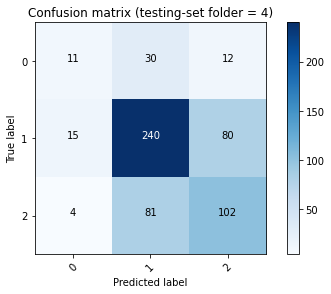

In [21]:
from sklearn.metrics import confusion_matrix
from pandas_ml import ConfusionMatrix

# K-folds cross validation
# K=5 or K=10 are generally used. 
# Note that the overall execution time increases linearly with k
k = 5

# Define the classes for the classifier
classes = ['0','1','2']

# Make Dataset random before start
df_rand = df.sample(df.storypoint.count(), random_state=99)

# Make datafrane to save results
results = pd.DataFrame(columns=['True_Classes', 'Predicted_Classes'])

# Number of examples in each fold
fsamples =  int(df_rand.storypoint.count() / k)

# Fill folds (obs: last folder could contain less than fsamples datapoints)
folds = list()
for i in range(k):
    folds.append(df_rand.iloc[i * fsamples : (i + 1) * fsamples])
        
# Init
sum_overall_accuracy = 0
total_predictions = 0

# Repeat k times and average results
for i in range(k):
    
    #1 - Build new training and testing set for iteration i
    training_set, testing_set  = rebuild_kfold_sets(folds, k, i)
    y_true = testing_set.storypoint.tolist()

    #2 - Oversample (ONLY TRAINING DATA)
    X_resampled, y_resampled =  SimpleOverSample(training_set.label_title_desc.values.tolist(), training_set.storypoint.values.tolist())
    
    #3 - train
    clf = FastTextClassifier()
    clf.fit(X_resampled, y_resampled)
    
    #4 - Predict
    y_pred = clf.predict(testing_set.label_title_desc.values.tolist())
    
    #3 - Update Overall Accuracy
    for num_pred in range(len(y_pred)):
        if(y_pred[num_pred] == y_true[num_pred]):
            sum_overall_accuracy += 1
        total_predictions += 1

    #4 - Plot Confusion Matrix and accuracy 
    plot_confusion_matrix_with_accuracy(classes, y_true, y_pred, 'Confusion matrix (testing-set folder = ' + str(i) + ')', sum_overall_accuracy, total_predictions)
    
    #5 - Save true and predicted labels in results dataframe
    results = results.append(pd.concat([pd.DataFrame({'True_Classes':y_true}), pd.DataFrame({'Predicted_Classes':y_pred})], axis=1))
    
# Save the results to .pkl file
results.reset_index()
results.to_pickle('appceleratorstudio_results.pkl') 

In [22]:
y_true = results['True_Classes'].tolist()
y_pred = results['Predicted_Classes'].tolist()

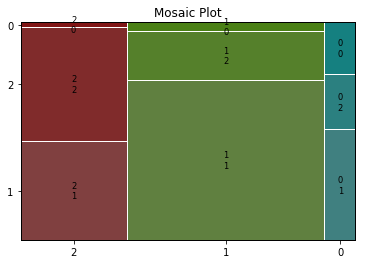

In [23]:
from statsmodels.graphics import mosaicplot

mosaicplot.mosaic(data=results, index=['True_Classes','Predicted_Classes'], title='Mosaic Plot')
plt.show()

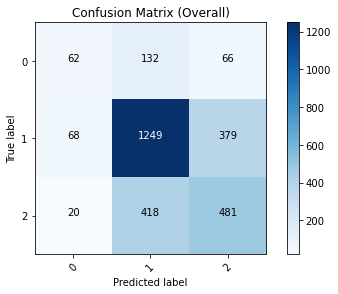

Cohen's Kappa value:  0.2800079638767429


C:\Users\hawkp\anaconda3\lib\site-packages\pandas_ml\confusion_matrix\stats.py:60: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  num = df[df > 1].dropna(axis=[0, 1], thresh=1).applymap(lambda n: choose(n, 2)).sum().sum() - np.float64(nis2 * njs2) / n2


In [24]:
cm = ConfusionMatrix(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure()
plot_confusion_matrix(conf_matrix, classes=classes, title='Confusion Matrix (Overall)')
plt.show()

print('Cohen\'s Kappa value: ', cm.stats()['overall']['Kappa'])

In [25]:
cm.stats()['class']

Classes,0,1,2
Population,2875,2875,2875
P: Condition positive,260,1696,919
N: Condition negative,2615,1179,1956
Test outcome positive,150,1799,926
Test outcome negative,2725,1076,1949
TP: True Positive,62,1249,481
TN: True Negative,2527,629,1511
FP: False Positive,88,550,445
FN: False Negative,198,447,438
"TPR: (Sensitivity, hit rate, recall)",0.238462,0.736439,0.523395


In [26]:
from sklearn.metrics import precision_recall_fscore_support

scores = precision_recall_fscore_support(y_true, y_pred)
print('Scores:')
print('Precision for classes {}: {}'.format(classes,scores[0]))
print('Recall for classes {}: {}'.format(classes,scores[1]))
print('F-Score for classes {}: {}'.format(classes,scores[2]))
print('Prediction count for classes {}: {}'.format(classes,scores[3]))

Scores:
Precision for classes ['0', '1', '2']: [0.41333333 0.6942746  0.51943844]
Recall for classes ['0', '1', '2']: [0.23846154 0.73643868 0.52339499]
F-Score for classes ['0', '1', '2']: [0.30243902 0.71473534 0.52140921]
Prediction count for classes ['0', '1', '2']: [ 260 1696  919]


In [8]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [1]:
import time
import datetime

In [15]:
import time
itimestr = str(time.strftime("%Y%m%d-%H%M%S"))
print (itimestr)
type(itimestr)

20210417-220406


str

End of Notebook

In [29]:
import pandas as pd

In [30]:
df=pd.DataFrame(columns={"m"})

In [31]:
value1="cool"

In [35]:
df=df.append({"cool":["cool","1","2"]},ignore_index=True)
df.head()

,m,cool
0,NaN,cool
1,NaN,"{cool, 2, 1}"
2,NaN,"[cool, 1, 2]"


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from sklearn.metrics import confusion_matrix
#from pandas_ml import ConfusionMatrix

In [7]:
y_true= [1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 2, 0, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1]
y_pred=  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1]

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

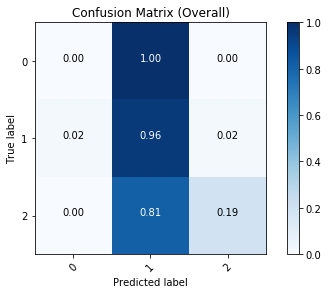

In [9]:
import itertools
classes=['0','1','2']
title="confusion matrix"
#cm = ConfusionMatrix(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
#plt.figure()
plot_confusion_matrix(conf_matrix, classes=classes, title='Confusion Matrix (Overall)')
#plt.show()

In [15]:
import sklearn
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score

In [17]:
'''fpr,tpr,threshold=roc_curve(y_true,y_pred)
auc_calculated=auc(fpr,tpr)

plt.figure(flsgsize=(5,5),dpi=100)
plt.plot(fpr,tpr,label='AUC: %0.3f'%auc_calculated)

plt.xlabel('False Positive Rate -->')
pt.ylabel('True Positive Rate -->')

plt.legend()
plt.show()'''

auc_multi=roc_auc_score(y_true,y_pred,multi_class="ovr")
print(auc_multi)

AxisError: axis 1 is out of bounds for array of dimension 1

In [20]:
outfile=open("predicted_results_xx.txt", mode="r")
test_pred = [(line.strip('_label\r\n')) for line in outfile.readlines()]
outfile.close()

#print(test_pred)
length=len(test_pred)

split_val=test_pred[length-1].split()
print(split_val)

label=int(split_val[0])
prob=float(split_val[1])
print(label," ",type(label))
print(prob," ",type(prob))


['2', '0.902306']
2   <class 'int'>
0.902306   <class 'float'>


In [30]:
outfile=open("predicted_results_xx.txt", mode="r")
test_pred = [(line.strip('_label\r\n')) for line in outfile.readlines()]
outfile.close()
y_pred=[]
prob=[]
length=len(test_pred)
for i in range (length):
            split_val=test_pred[i].split()
            label1=int(split_val[0])
            y_pred.append(label1)
            prob1=float(split_val[1])
            prob.append(prob1)
print("len:",len(y_pred))
print("y_pred: ",y_pred)
print("len:",len(prob))
print("prob: ",prob)

len: 184
y_pred:  [0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 2, 2, 2, 1, 1, 1, 2, 0, 2, 0, 0, 1, 0, 0, 2, 2, 2, 2, 0, 2, 1, 2, 0, 2, 2, 2, 2, 0, 1, 2, 0, 2, 0, 0, 0, 2, 0, 2, 1, 1, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 1, 2, 2, 2, 0, 2, 1, 1, 0, 2, 1, 0, 0, 2, 0, 2, 1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 0, 1, 0, 2, 1, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 2, 1, 1, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 2, 2, 1, 1, 2, 0, 0, 2, 0, 2, 0, 1, 2, 0, 0, 0, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2]
len: 184
prob:  [0.599552, 0.691223, 0.627304, 0.956339, 0.777759, 0.995202, 0.537939, 0.772705, 0.652609, 0.386304, 0.951615, 0.454667, 0.844728, 0.995444, 0.444733, 0.683523, 0.553967, 0.605593, 0.942716, 0.998897, 0.970675, 0.777759, 0.601836, 0.449339, 0.777759, 0.74529, 0.817188, 0.9759, 0.845495, 0.712307, 0.4326, 0.601836, 0.892691, 0.558071, 0.929526, 0.720892, 0.916051, 0.933345, 0.782864, 0.689988, 0.943189, 0.99783

In [88]:
import pandas as pd
import json
from sklearn.metrics import precision_recall_fscore_support

df=pd.read_csv("required_names.csv")
ss=df["file_access"].count()
ss2=ss*2
a=df["y_true"].count()
b=df["y_pred"].count()
c=df["y_prob"].count()

y_true=df["y_true"][a-ss]
y_pred=df["y_pred"][b+ss2]
y_prob=df["y_prob"][c+ss2]


print("\na:",a)
print("y_true:",y_true)
print("\nb:",b)
print("y_pred:",y_pred)
print("\nc:",c)
print("y_prob:",y_prob)

'''y_true2 = json.loads(y_true)
y_pred2 = json.loads(y_pred)
y_prob2 = json.loads(y_prob)'''

    

KeyError: 22

In [101]:
import pandas as pd
ytrue=[0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 2, 2, 2, 1, 1, 1, 2, 0, 2, 0, 0, 1, 0, 0, 2, 2, 2, 2, 0, 2, 1, 2, 0, 2, 2, 2, 2, 0, 1, 2, 0, 2, 0, 0, 0, 2, 0, 2, 1, 1, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 1, 2, 2, 2, 0, 2, 1, 1, 0, 2, 1, 0, 0, 2, 0, 2, 1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 0, 1, 0, 2, 1, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 2, 1, 1, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 2, 2, 1, 1, 2, 0, 0, 2, 0, 2, 0, 1, 2, 0, 0, 0, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2]
y_pred= [0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 2, 2, 2, 1, 1, 1, 2, 0, 2, 0, 0, 1, 0, 0, 2, 2, 2, 2, 0, 2, 1, 2, 0, 2, 2, 2, 2, 0, 1, 2, 0, 2, 0, 0, 0, 2, 0, 2, 1, 1, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 1, 2, 2, 2, 0, 2, 1, 1, 0, 2, 1, 0, 0, 2, 0, 2, 1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 0, 1, 0, 2, 1, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 2, 1, 1, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 2, 2, 1, 1, 2, 0, 0, 2, 0, 2, 0, 1, 2, 0, 0, 0, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2]
y_prob=[0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 2, 2, 2, 1, 1, 1, 2, 0, 2, 0, 0, 1, 0, 0, 2, 2, 2, 2, 0, 2, 1, 2, 0, 2, 2, 2, 2, 0, 1, 2, 0, 2, 0, 0, 0, 2, 0, 2, 1, 1, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 1, 2, 2, 2, 0, 2, 1, 1, 0, 2, 1, 0, 0, 2, 0, 2, 1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 0, 1, 0, 2, 1, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 2, 1, 1, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 2, 2, 1, 1, 2, 0, 0, 2, 0, 2, 0, 1, 2, 0, 0, 0, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2]
df=pd.read_csv("required_names.csv")

# Appending name of y_true

df["y_true"][1]=y_true
#df=df.append({"y_true":y_true},ignore_index=True)

# Appending name of y_pred
df["y_pred"][1]=y_pred
#df=df.append({"y_pred":y_pred},ignore_index=True)

# Appending name of prob
df["y_prob"][1]=y_prob
#df=df.append({"y_prob":prob},ignore_index=True)


head=["y_true","y_pred","y_prob"]
#df.to_csv("required_names.csv",index_label=head,mode='w',header=True,index=False)
df.to_csv("required_names.csv",index_label=head, index=False,mode='w')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [102]:
import pickle

In [142]:
y_true=[0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 2, 2, 2, 1, 1, 1, 2, 0, 2, 0, 0, 1, 0, 0, 2, 2, 2, 2, 0, 2, 1, 2, 0, 2, 2, 2, 2, 0, 1, 2, 0, 2, 0, 0, 0, 2, 0, 2, 1, 1, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 1, 2, 2, 2, 0, 2, 1, 1, 0, 2, 1, 0, 0, 2, 0, 2, 1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 0, 1, 0, 2, 1, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 2, 1, 1, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 2, 2, 1, 1, 2, 0, 0, 2, 0, 2, 0, 1, 2, 0, 0, 0, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2]
y_pred= [1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 2, 2, 2, 1, 1, 1, 2, 0, 2, 0, 0, 1, 0, 0, 2, 2, 2, 2, 0, 2, 1, 2, 0, 2, 2, 2, 2, 0, 1, 2, 0, 2, 0, 0, 0, 2, 0, 2, 1, 1, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 1, 2, 2, 2, 0, 2, 1, 1, 0, 2, 1, 0, 0, 2, 0, 2, 1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 0, 1, 0, 2, 1, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 2, 1, 1, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 2, 2, 1, 1, 2, 0, 0, 2, 0, 2, 0, 1, 2, 0, 0, 0, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2]
y_prob=[2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 2, 2, 2, 1, 1, 1, 2, 0, 2, 0, 0, 1, 0, 0, 2, 2, 2, 2, 0, 2, 1, 2, 0, 2, 2, 2, 2, 0, 1, 2, 0, 2, 0, 0, 0, 2, 0, 2, 1, 1, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 1, 2, 2, 2, 0, 2, 1, 1, 0, 2, 1, 0, 0, 2, 0, 2, 1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 0, 1, 0, 2, 1, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 2, 1, 1, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 2, 2, 1, 1, 2, 0, 0, 2, 0, 2, 0, 1, 2, 0, 0, 0, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2]
log=['file']
var=[y_true,y_pred,y_prob,log]
with open('variable.pickle', 'wb') as f:
    pickle.dump(var, f)

with open('variable.pickle', 'rb') as f:
        obj = pickle.load(f)
        
y_true=obj[0]
y_pred=obj[1]
y_prob=obj[2]

str

In [156]:
import pickle
import os
from os import path
file=["logfiles_1fa0fd78-94c6-4675-bf95-cc8011dcf8d9","logfiles_8dfc662f-4d3a-4981-af5b-c8ff3b3b6046","logfiles_8dfc662f-4d3a-4981-af5b-c8ff3b3b6046"]
with open('temp.pickle', 'wb') as f:
    pickle.dump(file, f)
with open('temp.pickle', 'rb') as f:
        obj = pickle.load(f)    
x=obj[1:]
for i in x:
        if(path.isdir(i)):
            print("yes")
            command = "rmdir -r " + i
            print(command)
            os.system(command)

yes
rmdir -r logfiles_8dfc662f-4d3a-4981-af5b-c8ff3b3b6046
yes
rmdir -r logfiles_8dfc662f-4d3a-4981-af5b-c8ff3b3b6046


In [146]:
for i in x:
    print(i

2
<class 'str'>
3
<class 'str'>
4
<class 'str'>


In [163]:
import pickle5 
import pandas as pd
with open('appceleratorstudio_results.pkl', "rb") as fh:
            pretrained = pickle5.load(fh)
with open('mosaic_results.pickle', 'wb') as f:
        pickle.dump(results, f)

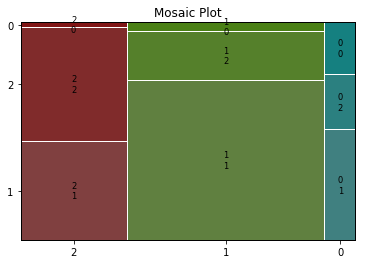

In [165]:
from statsmodels.graphics import mosaicplot
import matplotlib.pyplot as plt
mosaicplot.mosaic(data=pretrained, index=['True_Classes','Predicted_Classes'], title='Mosaic Plot')
plt.show()

In [1]:
from sklearn.metrics import precision_recall_fscore_support
import pickle
with open('variable.pickle', 'rb') as f:
            obj = pickle.load(f)
        
y_true=obj[0]
y_pred=obj[1]
y_prob=obj[2]
print(y_true)
print(y_pred)
print(y_prob)


scores = precision_recall_fscore_support(y_true, y_pred)

precision=scores[0]
print("precision:",precision)

recall=scores[1]
print("recall:",recall)

f_score=scores[2]
print("f_score:",f_score)

[2, 1, 2, 2, 1, 1, 1, 1, 2, 0, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 0, 2, 2, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 2, 1, 0, 1, 0, 0, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 2, 1, 2, 1, 0, 1, 1, 2, 1, 2, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 0, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 2, 2, 1, 2, 2, 0, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 0, 2, 0, 0, 1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 0, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 

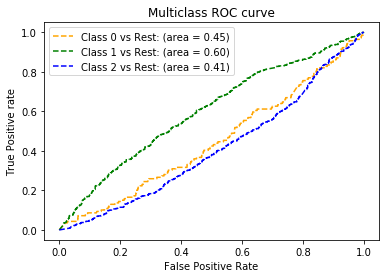

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from pandas_ml import ConfusionMatrix
# roc curve for classes

pred_prob=[0.993152, 0.804913, 0.999205, 0.997278, 0.903297, 0.999813, 0.995477, 0.646327, 0.951615, 0.562315, 0.998833, 0.998416, 0.959697, 0.992376, 0.983174, 0.999647, 0.994578, 0.99709, 0.774621, 0.994482, 0.943853, 0.782452, 0.999611, 0.976672, 0.94838, 0.999594, 0.666705, 0.998324, 0.995666, 0.892386, 0.992404, 1.00001, 0.99672, 0.999917, 0.977052, 0.709936, 0.872101, 0.991475, 0.97417, 0.773132, 0.999724, 0.954783, 0.863778, 0.991599, 0.816115, 0.951936, 0.999986, 0.474358, 0.893399, 0.529687, 0.861384, 0.600273, 1.00001, 0.996401, 0.984986, 0.950153, 0.95271, 0.998933, 0.987233, 0.74197, 0.895949, 0.996621, 0.990611, 0.998358, 0.999909, 0.816115, 0.996497, 0.807596, 0.969743, 0.907789, 0.961951, 0.990194, 0.990715, 0.999824, 0.999568, 0.900803, 0.869921, 0.931079, 0.993091, 0.998842, 0.939033, 0.995506, 0.991491, 0.988908, 0.968213, 0.981934, 0.97987, 0.92818, 0.99695, 0.997533, 0.997598, 0.972946, 0.999996, 0.982595, 0.865106, 0.482533, 0.990509, 0.74397, 0.863495, 0.806172, 0.623141, 0.999949, 0.976784, 1.00001, 0.77634, 0.888445, 0.657714, 0.996715, 0.996464, 0.926065, 0.999921, 0.668681, 0.976274, 0.987498, 0.676658, 0.990465, 0.640627, 0.964315, 0.998941, 0.917371, 0.418148, 0.998933, 0.803841, 0.562327, 0.999657, 0.50108, 0.916475, 0.535813, 0.997255, 0.950293, 0.965304, 0.987007, 0.936446, 0.956158, 0.807671, 0.984419, 0.842939, 0.920512, 0.995815, 0.981943, 0.983331, 0.931995, 0.532607, 0.968072, 0.999979, 0.999417, 0.961373, 0.999965, 0.981679, 0.900281, 0.856096, 0.971125, 0.995023, 0.856211, 0.527435, 0.684076, 0.866696, 0.668399, 0.996389, 0.987071, 0.816115, 0.994313, 0.985702, 1.00001, 0.894511, 0.999742, 0.96175, 0.991306, 0.951751, 0.999772, 0.92451, 0.965116, 0.443402, 0.644686, 0.876458, 0.955868, 0.631214, 0.98899, 0.999943, 0.983155, 0.977458, 1.00001, 0.751178, 0.999219, 0.540921, 0.992215, 0.814617, 0.709739, 0.977753, 0.999119, 0.939443, 0.756404, 0.995918, 0.999635, 0.962984, 0.93766, 0.999967, 0.64882, 0.977515, 0.986187, 0.880363, 0.998191, 0.996722, 0.954138, 0.890855, 0.996256, 0.97924, 0.990184, 0.516924, 0.582429, 0.994291, 0.999915, 0.970475, 0.998704, 0.97276, 0.994466, 0.959042, 0.996282, 0.717824, 0.898053, 0.9058, 0.956777, 0.999665, 0.750645, 0.817707, 0.998872, 0.594494, 0.496967, 0.551442, 0.982052, 0.999451, 0.950146, 0.982458, 0.996238, 0.893407, 0.999934, 0.798647, 0.576357, 0.999309, 0.96964, 1.0, 0.978837, 0.729996, 0.721445, 0.999804, 0.954549, 0.826441, 0.880761, 0.794476, 0.624731, 0.766339, 0.932733, 0.566244, 0.860776, 1.0, 0.648909, 0.99923, 0.907574, 0.581479, 0.972272, 0.906626, 0.938428, 0.695269, 0.999556, 0.999676, 0.945729, 0.980871, 0.922031, 0.949404, 0.561407, 0.99984, 0.966236, 0.999982, 0.453937, 0.994774, 0.764113, 0.979177, 0.821799, 0.990371, 0.987956, 0.821815, 0.987906, 0.991775, 0.773248, 0.999118, 0.516184, 0.987643, 0.945419, 0.997106, 0.999979, 0.988757, 0.999084, 0.991011, 0.998455, 0.616812, 0.9264, 0.971761, 0.891544, 0.632095, 0.999554, 0.821651, 0.541505, 0.708585, 0.687464, 0.992489, 0.876022, 0.851777, 0.983671, 0.99993, 0.668392, 0.999887, 0.999739, 0.712214, 0.999417, 0.989515, 0.999971, 0.997669, 0.941538, 0.999447, 0.986496, 0.520802, 0.996882, 0.999825, 0.724986, 0.919904, 0.951895, 0.992499, 0.992022, 0.995848, 1.0, 0.992704, 0.971496, 0.998854, 0.907693, 0.88933, 0.657427, 0.648428, 0.99776, 0.799364, 1.0, 0.971628, 0.999674, 0.5678, 0.816115, 0.995258, 0.879776, 0.999993, 0.937837, 0.965036, 0.801201, 0.978055, 0.999176, 0.762492, 0.92457, 0.999928, 0.504689, 0.816115, 0.966256, 0.982554, 0.999997, 0.970668, 0.999934, 0.996885, 0.975757, 0.972212, 0.997126, 0.87786, 0.992937, 0.998939, 0.98917, 0.855316, 0.857341, 0.674335, 0.957036, 0.999946, 0.981268, 0.984558, 0.993536, 0.97475, 0.67931, 0.9967, 0.988564, 0.924899, 0.744397, 0.999115, 0.959322, 0.999011, 0.866276, 0.989271, 0.998315, 0.972313, 0.997768, 0.929784, 0.669396, 0.957492, 0.990588, 0.615173, 0.986347, 0.999867, 0.91272, 0.902467, 0.666064, 0.995321, 0.992827, 0.863995, 0.710092, 0.933976, 0.53555, 0.994885, 0.76204, 1.00001, 0.991367, 0.988605, 0.997817, 0.995293, 0.971098, 0.942598, 0.902663, 0.534765, 0.999684, 0.726237, 0.360011, 0.563685, 0.74072, 0.973021, 0.963531, 0.999874, 0.997065, 0.965239, 0.959088, 0.997946, 0.863987, 0.577816, 0.935809, 0.999626, 0.998367, 0.812657, 0.727183, 0.766738, 0.833776, 0.994471, 0.972497, 0.994487, 0.968657, 0.566121, 0.986515, 0.856175, 0.725415, 0.983605, 0.978869, 0.999296, 0.999313, 0.986048, 0.999998, 0.913901, 0.816115, 0.995127, 0.932277, 0.865182, 0.999929, 0.923539, 0.997762, 0.998916, 0.98513, 0.942499, 0.990763, 0.99741, 0.696409, 0.991096, 0.688814, 0.936813, 0.651898, 0.700582, 0.951796, 0.999749, 0.810679, 0.99918, 0.94648, 0.922068, 0.998651, 0.816115, 0.996347, 0.641207, 0.950565, 0.973888, 0.816115, 0.851944, 0.995507, 0.987269, 0.999012, 0.981314, 0.856198, 0.630231, 0.999635, 0.999993, 0.958821, 0.809501, 0.963602, 0.99312, 0.964249, 0.934951, 0.985092, 0.997029, 0.935274, 0.560537, 0.948651, 0.990545, 0.999173, 0.998158, 0.99915, 0.994625, 0.545676, 0.549138, 0.880738, 0.694145, 0.514481, 0.881998, 0.998999, 0.995508, 0.975244, 1.00001, 0.857746, 0.890847, 0.866709, 0.999908, 0.858923, 0.999918, 0.531198, 0.994194, 0.999752, 0.983446, 0.999329, 0.930804, 0.983378, 0.97171, 0.841916, 1.0, 0.607374, 0.998874, 0.968696, 0.950071, 0.816115, 0.831878, 0.838747, 0.850037, 0.83139, 0.755081, 0.984869, 0.745227, 0.97069, 0.859352, 0.716795, 0.99284, 0.931226, 0.684762, 0.631328, 0.631409, 0.963087, 0.697815, 0.673441, 0.998944, 0.99907, 0.8995, 0.993633, 0.998351, 0.998157, 0.999902, 0.580413, 0.779701, 0.999447, 0.910841, 0.996864, 0.989213, 0.970289, 0.999498, 1.00001, 0.997133, 0.753996, 0.78876, 0.923849, 0.999986, 0.812194, 0.999763, 0.970081, 0.991286, 0.775013, 0.989305, 0.988376, 0.489096, 0.999912, 0.960489, 0.949793, 0.994552, 0.874305, 0.731891, 0.999151, 0.999597, 0.998455, 0.417224, 0.997676, 0.422693, 0.973037, 0.874643, 0.918083, 0.999997, 0.816115, 0.816115, 0.755246, 0.960582, 0.960768, 1.0, 0.999742, 0.816115, 0.94138, 0.575355, 0.918171, 0.989759, 0.992752, 0.992073, 0.982879, 0.619524, 0.935479, 0.931458, 0.967004, 0.998689, 0.959121, 0.983407, 0.99597, 0.995397, 0.999997, 1.00001, 0.886961, 0.961913, 0.785455, 0.501421, 0.999244, 0.999982, 0.994959, 0.808195, 0.999941, 0.999901, 0.779572, 0.99646, 0.999345, 0.847467, 0.999989, 0.997511, 0.958818, 0.99941, 1.00001, 0.808414, 0.996746, 0.974267, 0.745526, 0.921167, 0.965698, 0.993798, 1.00001, 0.576983, 0.503788, 0.965365, 0.999369, 0.998886, 0.997846, 0.99904, 0.993797, 0.537539, 0.842303, 0.904456, 0.999151, 0.755813, 0.99889, 0.998093, 0.881937, 0.964003, 0.884697, 0.950092, 0.999626, 0.984793, 0.873751, 0.9919, 0.626975, 0.999229, 0.534753, 0.931417, 0.797726, 0.592754, 0.991361, 0.843782, 0.99947, 0.940804, 0.991751, 0.963623, 0.995555, 0.635836, 0.999553, 0.939177, 0.987788, 0.989888, 0.983817, 0.802967, 0.89025, 0.999902, 0.99998, 0.89068, 0.987063, 0.999981, 0.991686, 0.995424, 0.992714, 0.993179, 0.994932, 0.441276, 0.784051, 0.994082, 0.996923, 0.967459, 0.995457, 0.931365, 0.689914, 0.558041, 0.948425, 0.93974, 0.999574, 0.817089, 0.832414, 0.588735, 0.996417, 0.80382, 0.97627, 0.998044, 0.756605, 0.998897, 0.924823, 0.985757, 0.952129, 0.993152, 0.964205, 0.943161, 0.883668, 0.987178, 0.987753, 0.453375, 0.786633, 0.516354, 0.865408, 0.995508, 0.955095, 0.995028, 0.961758, 0.989704, 0.816115, 0.96629, 0.978597, 0.999984, 0.621063, 0.747048, 0.985972, 0.726279, 0.594014, 0.649798, 0.983509, 0.996835, 0.90442, 0.857365, 0.989096, 0.931969, 0.915972, 0.855076, 0.376616, 0.997536, 0.838009, 0.66818, 0.657929, 0.985846, 0.77594, 0.996404, 0.912597, 0.731056, 0.99312, 0.989618, 0.816115, 0.867135, 1.00001, 0.544542, 0.873438, 0.960186, 0.740275, 0.996401, 0.970527, 0.996143, 0.964289, 0.594912, 0.991676, 0.999759, 0.522816, 0.892081, 0.540698, 0.87957, 0.854574, 0.9196, 0.997457, 0.849788, 0.884286, 0.940653, 0.981028, 0.998837, 0.5201, 0.669396, 0.894062, 0.998334, 0.829278, 0.893242, 0.787918, 0.979652, 0.999644, 0.577923, 0.94176, 0.999487, 0.990961, 0.944811, 0.99193, 0.785806, 0.970653, 0.996933, 0.98396, 0.883857, 0.816115, 0.907627, 0.591078, 0.977482, 0.999848, 0.99958, 0.999864, 0.998944, 0.734573, 0.967454, 0.626409, 0.997166, 0.994356, 0.972946, 0.99836, 0.966608, 0.966455, 0.999948, 0.981868, 0.805446, 0.982271, 0.998081, 0.997195, 0.959044, 0.834856, 0.591302, 0.999167, 0.999995, 0.948205, 0.775651, 0.994079, 0.656265, 0.739342, 0.87843, 0.994655, 0.849861, 0.895764, 0.986565, 0.970271, 0.535564, 1.00001, 0.670149, 0.561975, 0.837293, 0.531948, 0.954403, 0.939981, 0.995227, 0.9996, 0.885531, 0.695624, 0.935388, 0.700292, 0.97964, 0.999231, 0.589084, 0.998167, 0.934222, 0.976731, 0.847968, 0.899636, 0.998709, 0.618932, 0.972947, 0.985536, 0.563624, 0.409632, 0.955186, 0.928915, 0.90086, 0.599328, 0.911017, 0.991915, 0.999604, 0.99997, 0.969306, 0.985497, 0.9888, 1.00001, 0.746178, 0.999611, 0.99251, 0.986527, 0.799268, 0.977534, 0.956511, 0.824638, 0.999647, 0.816115, 0.99969, 0.995493, 0.97989, 0.784591, 0.97513, 0.885859, 0.993209, 0.999256, 0.921778, 0.918423, 0.506152, 0.50278, 0.99888, 0.65963, 0.919873, 0.697009, 0.987935, 0.396919, 0.999964, 0.592639, 0.9833, 0.839639, 0.949775, 0.999306, 0.992184, 0.996824, 0.531729, 0.786043, 0.868763, 0.997643, 0.510956, 0.999959, 0.841325, 0.998093, 0.999262, 0.927404, 0.592284, 0.990459, 0.830524, 0.529064, 0.934807, 0.999963, 0.998867, 0.987928, 0.957421, 0.990382, 0.995961, 0.991689, 0.969917, 0.966075, 0.995164, 0.964492, 0.964329, 0.988844, 0.723976, 0.988086, 0.926839, 0.614424, 0.816115, 0.999042, 0.980671, 0.816115, 0.656814, 0.983624, 0.851085, 0.99802, 0.999998, 0.99175, 0.615255, 0.947068, 0.981469, 0.981166, 0.502157, 0.931379, 0.884563, 0.612073, 0.505601, 0.759094, 0.999147, 0.827456, 1.00001, 0.680637, 0.510625, 0.97118, 0.999013, 1.00001, 0.998576, 0.919864, 0.999951, 0.964283, 0.879834, 0.53381, 0.999627, 0.999966, 0.983552, 0.930211, 0.996152, 0.977037, 0.997452, 0.823706, 0.983551, 0.985617, 0.999863, 0.663467, 0.998578, 0.78253, 0.968861, 0.999849, 0.997567, 0.63353, 0.869666, 0.999986, 0.998796, 0.983933, 0.936118, 0.966639, 0.824244, 0.803684, 0.881596, 0.955403, 0.992023, 0.982235, 0.998086, 0.999096, 0.999389, 0.984627, 0.99807, 0.968126, 0.991825, 0.539291, 0.980793, 0.959947, 0.972476, 0.617708, 0.980595, 0.909626, 0.992905, 0.993941, 0.846517, 0.996299, 0.992863, 0.864642, 0.999852, 0.979426, 0.701729, 0.528929, 0.851513, 0.98916, 0.992667, 0.816115, 0.748902, 0.829568, 0.992854, 0.998313, 0.982216, 0.977007, 0.992711, 0.670763, 0.827963, 0.852735, 0.56916, 0.777861, 0.812859, 0.999308, 0.999513, 0.999294, 0.868281, 0.997984, 0.983166, 0.997736, 0.999956, 0.999489, 0.969487, 0.989499, 0.890478, 0.88546, 1.00001, 0.997535, 0.973102, 0.996177, 0.987048, 0.550122, 0.999896, 1.00001, 0.645641, 0.990143, 0.938169, 0.682688, 0.700048, 0.655613, 0.816115, 0.970398, 0.989517, 0.990743, 0.9692, 0.999626, 0.928352, 0.453799, 1.00001, 0.994838, 0.997173, 0.999657, 0.984687, 0.988455, 0.974031, 0.653539, 0.986014, 0.598577, 0.999681, 0.556585, 0.89634, 0.993442, 0.997184, 0.948613, 0.622951, 1.00001, 0.941682, 0.816115, 0.999924, 0.998061, 0.814439, 0.644557, 0.994919, 0.866268, 0.921106, 0.512472, 0.584373, 0.99999, 0.998771, 0.75324, 0.999576, 0.964551, 0.992649, 0.816115, 0.816115, 0.816115, 0.999236, 0.772516, 0.985178, 0.999037, 0.965113, 0.997408, 0.999818, 0.883291, 1.00001, 0.782251, 0.99934, 0.975679, 0.998644, 0.982308, 0.996014, 0.785279, 0.679358, 0.999951, 0.999975, 0.902409, 0.992583, 0.999745, 0.957434, 0.778574, 0.998164, 0.615411, 0.79459, 0.511697, 0.987867, 0.976257, 0.679082, 0.505392, 0.891998, 0.947489, 0.998507, 0.524998, 0.955261, 0.937436, 0.956473, 0.98229, 0.70851, 0.993699, 0.967272, 1.00001, 0.928237, 0.999989, 0.999967, 0.995978, 0.999104, 0.999842, 0.930969, 0.999628, 0.558073, 0.999715, 0.84461, 0.99876, 0.995703, 0.42942, 0.894099, 0.928795, 0.936844, 0.942435, 0.824563, 0.952544, 0.995764, 0.991645, 0.999905, 0.910717, 0.528605, 0.975672, 0.998744, 0.930952, 0.927815, 0.999732, 0.85424, 0.481751, 0.765769, 0.995792, 0.792803, 0.944712, 0.899602, 0.999634, 0.93237, 0.913682, 0.981743, 0.655539, 0.988715, 0.99494, 0.990509, 0.992473, 0.916755, 0.984949, 0.829465, 0.998446, 0.999948, 0.99217, 0.549912, 0.928361, 0.991762, 0.983293, 0.446244, 0.886816, 0.994955, 0.966214, 0.992717, 0.998914, 0.996641, 0.752038, 0.99779, 0.928004, 0.985521, 0.987249, 0.900562, 1.0, 0.987424, 0.996658, 0.989804, 0.999993, 0.995004, 0.999126, 0.723427, 0.91996, 0.999804, 0.995227, 0.973132, 0.999828, 0.999709, 0.437264, 0.913774, 0.676506, 0.909123, 0.763359, 0.938715, 0.90334, 0.923308, 0.843161, 0.974973, 0.997441, 0.634389, 0.999432, 0.998904, 0.972913, 0.976958, 0.776704, 0.804265, 0.995006, 0.997395, 0.921258, 0.738448, 0.994787, 0.964496, 0.754617, 0.999845, 0.741089, 0.984094, 0.986221, 0.999705, 0.828718, 0.978939, 0.970514, 0.933103, 0.999612, 0.959777, 0.999917, 0.83774, 0.532433, 0.984836, 0.96392, 0.997621, 0.989291, 1.00001, 0.99288, 0.997714, 0.872988, 0.827237, 0.590157, 0.999973, 0.999786, 0.588515, 0.989453, 0.970999, 0.996097, 0.979311, 0.698847, 0.38915, 0.506701, 0.999735, 0.999125, 0.97948, 0.75288, 0.875461, 0.614149, 0.551634, 0.923975, 0.854636, 0.943565, 0.984745, 0.761164, 0.999814, 0.897412, 0.97076, 0.999496, 0.819367, 0.486621, 0.568944, 0.668481, 0.997966, 0.998529, 0.920865, 0.999851, 1.00001, 0.998403, 0.99784, 0.862531, 0.876864, 0.652876, 0.816115, 0.941423, 0.874836, 0.99769, 0.546633, 0.967006, 0.686831, 0.824002, 0.70767, 0.993704, 0.699801, 0.990557, 0.904016, 0.582653, 0.995906, 0.988639, 0.87114, 0.521763, 0.633916, 0.994652, 0.669537, 0.936098, 0.998853, 0.600789, 0.999424, 0.998758, 0.999447, 0.892639, 0.991652, 0.999135, 0.987006, 0.728489, 0.707859, 0.728955, 0.98587, 0.767475, 0.935378, 0.97388, 0.930548, 0.725796, 0.611612, 0.862145, 0.943179, 0.793471, 0.677245, 0.997027, 0.99852, 0.621976, 0.973442, 1.00001, 0.758229, 0.562479, 0.746885, 0.595712, 0.912257, 0.813201, 0.930825, 0.913682, 0.997861, 0.962772, 0.997025, 0.971926, 0.827295, 0.891737, 0.860422, 0.855146, 0.820361, 0.870582, 0.975586, 0.999979, 0.817221, 0.99034, 0.942553, 0.849047, 0.854086, 0.982993, 0.587133, 0.999758, 0.997863, 0.972429, 0.983876, 0.911661, 0.871335, 0.780082, 1.0, 0.649901, 0.733708, 0.76625, 0.739763, 0.996839, 0.718828]
y_pred=[1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 0, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 0, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 0, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 1, 1, 1, 1, 2, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 0, 2, 2, 1, 1, 0, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 0, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 0, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 0, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 0, 2, 1, 1, 2, 2, 2, 0, 1, 0, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 2, 2, 1, 0, 0, 2, 2, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 0, 2, 2, 1, 1, 1, 1, 2, 1, 0, 0, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 1, 0, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 2, 0, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 0, 0, 2, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 0, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 0, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 0, 1, 1, 0, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 0, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 0, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 0, 0, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1]
y_true=[2, 1, 2, 2, 1, 1, 1, 1, 2, 0, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 0, 2, 2, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 2, 1, 0, 1, 0, 0, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 2, 1, 2, 1, 0, 1, 1, 2, 1, 2, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 0, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 2, 2, 1, 2, 2, 0, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 0, 2, 0, 0, 1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 0, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 0, 2, 0, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1, 0, 2, 1, 2, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 0, 0, 2, 2, 2, 2, 0, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 0, 1, 1, 2, 2, 2, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 0, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1, 0, 2, 1, 1, 0, 2, 1, 0, 1, 2, 1, 0, 1, 1, 2, 2, 2, 1, 1, 0, 1, 1, 0, 0, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 0, 2, 1, 0, 1, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 0, 2, 2, 1, 0, 2, 1, 1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 0, 2, 1, 1, 0, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 0, 2, 1, 1, 2, 0, 1, 2, 2, 0, 1, 1, 2, 2, 1, 0, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 0, 2, 0, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 0, 2, 0, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 0, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 0, 0, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 2, 1, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 0, 1, 2, 0, 1, 2, 0, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 0, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 0, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 0, 2, 1, 2, 2, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 0, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 0, 2, 1, 1, 2, 1, 2, 0, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 0, 0, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 0, 1, 0, 2, 2, 2, 0, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 0, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 0, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 0, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 0, 1, 2, 2, 0, 2, 1, 1, 1, 2, 1, 2, 2, 0, 2, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 0, 2, 0, 1, 2, 1, 1, 2, 1, 2, 0, 1, 2, 1, 0, 2, 1, 1, 2, 2, 1, 1, 1, 0, 2, 2, 2, 2, 0, 2, 1, 1, 2, 1, 1, 2, 2, 0, 1, 2, 1, 1, 0, 2, 2, 1, 2, 1, 2, 1, 1, 2, 0, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 0, 1, 2, 2, 0, 1, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 0, 1, 1, 1, 2, 1, 1]
fpr = {}
tpr = {}
thresh ={}

n_class = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_class): 
    fpr[i], tpr[i], thresh[i] = roc_curve(y_true, pred_prob,pos_label=i)
    #fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob,pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest: (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest: (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest: (area = %0.2f)' % roc_auc[2])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()



In [6]:
a= [1,2,3,4,5]
for i in a:
    print(a[:i])
    

[1]
[1, 2]
[1, 2, 3]
[1, 2, 3, 4]
[1, 2, 3, 4, 5]


In [7]:
cm = ConfusionMatrix(y_true, y_pred)

sum_overall_accuracy = 0
total_predictions = 0
    
for num_pred in range(len(y_pred)):
        if(y_pred[num_pred] == y_true[num_pred]):
            sum_overall_accuracy += 1
        total_predictions += 1
        
print('Current Overall accuracy: ' + str(cm.stats()['overall']['Accuracy']))
if total_predictions != 0:
        print('Total Overall Accuracy: ' + str(sum_overall_accuracy/total_predictions))
else:
        print('Total Overall Accuracy: ' + str(cm.stats()['overall']['Accuracy']))
        
        

C:\ProgramData\Anaconda3\lib\site-packages\pandas_ml\confusion_matrix\stats.py:60: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  num = df[df > 1].dropna(axis=[0, 1], thresh=1).applymap(lambda n: choose(n, 2)).sum().sum() - np.float64(nis2 * njs2) / n2


Current Overall accuracy: 0.6120630568882797
Total Overall Accuracy: 0.6120630568882797
